In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
import seaborn as sns
# from category_encoders import TargetEncoder

## Preliminary Dataset Exploration

The dataset consists of 3 months worth of packing and order data from an e-Commerce packing facility.

Each row in the dataset represents a product being purchased

The objective of this project is create an automatic carton box recommendation system. This means that the carton_type is the target variable.

In [2]:
df = pd.read_excel('../data/outbound_data_finalv1.xlsx', sheet_name='data')
df

,carton_id,carton_type,orderkey,orderline,orderdate,country,sku,skucat,qtyshipped,storage_type,len_mm,wid_mm,hgt_mm,vol_dm3,isgift
0,390081941033894136,C211,2291743,2,44627.588426,KR,5522774,18,1,MS,89.0,89.0,36.0,0.285156,1
1,390081941033895195,C211,2291745,2,44627.588576,KR,5533397,18,1,MS,89.0,89.0,36.0,0.285156,1
2,390081941033895775,C211,2291760,2,44627.589514,KR,5567934,18,1,MS,104.0,83.0,59.0,0.509288,1
3,390081941036292014,C211,2291768,2,44627.589664,KR,5562084,18,1,MS,145.0,91.0,42.0,0.554190,1
4,390081941036300641,C211,2291772,2,44627.589907,KR,5636421,18,1,MS,89.0,89.0,36.0,0.285156,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62236,390081941037460412,C321,2565691,2,44712.508125,AU,5521027,18,1,MS,102.0,102.0,81.0,0.842724,0
62237,390081941036765006,C211,2565692,1,44712.508160,AU,5347329,18,1,MS,89.0,89.0,36.0,0.285156,0
62238,390081941036765006,C211,2565692,2,44712.508160,AU,5531287,18,1,MS,72.0,70.0,32.0,0.161280,0
62239,390081941037423615,C211,2565693,1,44712.508194,AU,5518871,18,1,MS,104.0,83.0,59.0,0.509288,0


In [3]:
len(df['orderkey'].unique())

32726

There are 62241 rows of data in the dataset but only 32726 orders.

Since the target variable is carton_type, but the carton_type is determined at the order level, this means that there needs to be some aggregation to consolidate the rows into the order level.

## Preprocessing Data

#### Cleaning of data

First, we drop the columns that are repeated identifier data. We will be using orderkey as the identifier in this instance

In [4]:
df_noid=df.drop(columns=['sku','orderline','orderdate','carton_id'])
df_noid['vol_dm3']=df_noid['vol_dm3']*df_noid['qtyshipped']
df_noid

,carton_type,orderkey,country,skucat,qtyshipped,storage_type,len_mm,wid_mm,hgt_mm,vol_dm3,isgift
0,C211,2291743,KR,18,1,MS,89.0,89.0,36.0,0.285156,1
1,C211,2291745,KR,18,1,MS,89.0,89.0,36.0,0.285156,1
2,C211,2291760,KR,18,1,MS,104.0,83.0,59.0,0.509288,1
3,C211,2291768,KR,18,1,MS,145.0,91.0,42.0,0.554190,1
4,C211,2291772,KR,18,1,MS,89.0,89.0,36.0,0.285156,1
...,...,...,...,...,...,...,...,...,...,...,...
62236,C321,2565691,AU,18,1,MS,102.0,102.0,81.0,0.842724,0
62237,C211,2565692,AU,18,1,MS,89.0,89.0,36.0,0.285156,0
62238,C211,2565692,AU,18,1,MS,72.0,70.0,32.0,0.161280,0
62239,C211,2565693,AU,18,1,MS,104.0,83.0,59.0,0.509288,0


Details regarding the dimensions of the carton types will be used to conduct a sanity check which will be explained shortly.

In [5]:
carton = pd.read_excel('../data/cartontable.xlsx')
carton.rename(columns = {'cartonsize':'carton_type', 'maxcube':'carton_vol'},inplace = True)
carton.head()

,carton_type,carton_vol,giftcube,len,giftlen,wid,giftwid,hgt
0,C211,2.65,1.62,240,180,160,120,75
1,C321,5.25,4.95,250,220,180,180,125
2,C431,8.30,8.10,390,340,280,280,85
3,C432,20.50,18.36,390,340,300,300,180
4,C543,60.00,57.60,500,450,400,400,320


This is a sanity check function to ensure that the volumes of the items for each does not exceed the volume of the cartons they are stored in. This is a simple check to eliminate any potential data entry errors. Moving forward, the data after the sanity check will be assumed to be optimal, meaning the cartons that the orders are stored in are the ideal size of cartons.

In [6]:
def sanity_check(sales,carton):
    merged=sales.merge(carton,how='inner',on='carton_type')
    merged.set_index('orderkey',inplace=True)
    idx=merged.index[merged['sum_vol']<=merged['carton_vol']]
    return sales.loc[idx]

#### Data aggregation

As mentioned earlier, the data will need to be aggregated into the order level. As such, functions such as max, sum and mode will be used to aggregate the data in the dataset at the order level.

For most of the features to be aggregated, it was straightforward to find out which aggregation will best represent each orderkey. However, for the dimensions of the products, trial and error was used to determine which of the aggregation functions yielded better results when testing the machine learning model on the test data. It was found that the max aggregate function worked best for the dimensions. 

(To prevent this python notebook from being too long, only the max aggregate function will be used for the dimensions in this notebook. Note that other measures such as multiplying the the qtyshipped with the dimensions were also considered but not used in this project, but can be considered in future work.)

In [7]:

from statistics import mode


df1 = df_noid.groupby('orderkey')[['skucat','country','qtyshipped','storage_type','vol_dm3','carton_type', 'isgift', 'orderkey','len_mm','wid_mm','hgt_mm']].agg(#lambda x : list(x))
    carton_type = pd.NamedAgg(column='carton_type', aggfunc = max),
    orderkey = pd.NamedAgg(column='orderkey', aggfunc = max),
    len_mm = pd.NamedAgg(column='len_mm', aggfunc = max),
    wid_mm = pd.NamedAgg(column='wid_mm', aggfunc = max),
    hgt_mm = pd.NamedAgg(column='hgt_mm', aggfunc = max),
    skucat = pd.NamedAgg(column='skucat', aggfunc = mode),
    sum_vol = pd.NamedAgg(column='vol_dm3', aggfunc = sum),
    isgift = pd.NamedAgg(column='isgift', aggfunc = max),
    qtyshipped = pd.NamedAgg(column='qtyshipped', aggfunc = sum),
    country = pd.NamedAgg(column='country', aggfunc = mode),
    storage_type = pd.NamedAgg(column='storage_type', aggfunc = mode))
df1


,carton_type,orderkey,len_mm,wid_mm,hgt_mm,skucat,sum_vol,isgift,qtyshipped,country,storage_type
orderkey,,,,,,,,,,,
2291743,C211,2291743,89.0,89.0,36.0,18,0.285156,1,1,KR,MS
2291745,C211,2291745,89.0,89.0,36.0,18,0.285156,1,1,KR,MS
2291760,C211,2291760,104.0,83.0,59.0,18,0.509288,1,1,KR,MS
2291768,C211,2291768,145.0,91.0,42.0,18,0.554190,1,1,KR,MS
2291772,C211,2291772,89.0,89.0,36.0,18,0.285156,1,1,KR,MS
...,...,...,...,...,...,...,...,...,...,...,...
2565686,C321,2565686,118.0,82.0,82.0,34,0.793432,1,1,AU,MS
2565687,C431,2565687,152.0,122.0,54.0,18,3.004128,0,3,AU,MS
2565691,C321,2565691,102.0,102.0,81.0,18,1.092366,0,2,AU,MS


Import the recommended cartons by the heuristic

In [8]:
new_carton = pd.read_excel('../data/recommended_ctn.xlsx',index_col='orderkey')
new_carton.head()

,recommend_ctn
orderkey,
2291743,C211
2291745,C211
2291760,C211
2291768,C211
2291772,C211


Set the carton_type column to be the cartons recommended by the heuristic

In [9]:
df1['carton_type']=new_carton['recommend_ctn']
df1

,carton_type,orderkey,len_mm,wid_mm,hgt_mm,skucat,sum_vol,isgift,qtyshipped,country,storage_type
orderkey,,,,,,,,,,,
2291743,C211,2291743,89.0,89.0,36.0,18,0.285156,1,1,KR,MS
2291745,C211,2291745,89.0,89.0,36.0,18,0.285156,1,1,KR,MS
2291760,C211,2291760,104.0,83.0,59.0,18,0.509288,1,1,KR,MS
2291768,C211,2291768,145.0,91.0,42.0,18,0.554190,1,1,KR,MS
2291772,C211,2291772,89.0,89.0,36.0,18,0.285156,1,1,KR,MS
...,...,...,...,...,...,...,...,...,...,...,...
2565686,C321,2565686,118.0,82.0,82.0,34,0.793432,1,1,AU,MS
2565687,C321,2565687,152.0,122.0,54.0,18,3.004128,0,3,AU,MS
2565691,C321,2565691,102.0,102.0,81.0,18,1.092366,0,2,AU,MS


In [10]:
df_max=df1

df_max will be the main Dataframe used in the training process after the data cleaning and preprocessing.

The test dataset is an out of sample data of 4000 orders. This is to test the generalisability of the model should there be any changes the dimensions of the products in the orders.


In [11]:
test=pd.read_excel('../data/out_of_sample_recommend.xlsx',index_col='orderkey')
test.drop(['orderkey1','actual_carton','planned_ctn'],axis=1,inplace=True)
test.rename(columns = {'recommend_ctn':'carton_type', 'max_len':'len_mm', 'max_wid':'wid_mm', 'max_hgt':'hgt_mm'},inplace = True)
test

,len_mm,wid_mm,hgt_mm,sum_vol,isgift,qtyshipped,carton_type
orderkey,,,,,,,
2996514,154.0,125,32,0.616000,1,1,C321
2996518,118.0,82,82,1.210320,0,2,C321
2996520,104.0,83,59,0.509288,1,1,C211
2996522,226.0,89,70,1.977796,1,4,C431
2996523,225.0,89,70,1.751562,1,3,C431
...,...,...,...,...,...,...,...
3062581,111.0,92,53,0.541236,0,1,C211
3062582,81.0,67,46,0.249642,1,1,C211
3062586,123.0,120,118,1.741680,1,1,C321


test will be the dataframe used for testing and evaluation of the final mode.

## Analysis

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
from category_encoders import TargetEncoder
from sklearn import neighbors, metrics, preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

Split df_max into a train and test set

In [13]:
df_max = df_max.astype({'skucat': 'str', 'isgift': 'str','country': 'str', 'storage_type': 'str'})
y_train = df_max.carton_type
X_train = df_max.drop('carton_type',axis=1)
# y = df_max.carton_type
# X = df_max.drop('carton_type',axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [14]:
test = test.astype({'isgift': 'str'})
y_test = test.carton_type
X_test = test.drop('carton_type',axis=1)

### Feature Selection

Feature selection will be done first before the resampling of data

In [15]:
X_num = X_train.loc[:,['len_mm','wid_mm','hgt_mm','sum_vol','qtyshipped']]
skb = SelectKBest(mutual_info_classif, k=5)
skb.fit(X_num, y_train)
skb.scores_.round(4)

array([0.4258, 0.3648, 0.3798, 0.6591, 0.1183])

In [16]:
X_cat_df = X_train.loc[:,['skucat','isgift','country','storage_type'] ]
oe1 = OrdinalEncoder()
oe1.fit(X_cat_df)
X_cat = oe1.transform(X_cat_df)

In [17]:
skb2 = SelectKBest(mutual_info_classif, k=3)
skb2.fit(X_cat, y_train)
skb2.scores_.round(4)


array([0.1236, 0.0098, 0.0053, 0.0132])

From the above, it is clear that len_mm, wid_mm, hgt_mm, sum_vol, qtyshipped, isgift and skucat are the features which are more informative in the classification of carton_types.

In [18]:
df_max.skucat.value_counts()

18    27146
34     2084
14     1737
58      804
47      706
94      147
48       70
20       25
45        7
Name: skucat, dtype: int64

Since skucat only has 7 occurences of category 45, this may result in the category not being present in both the train and test dataset. As such, we will be exlcuding it as a feature despite indication that it is one of the more informative features.

Thus the final feature set will have the following 6 features as seen below.

In [19]:
num_features = ['len_mm','wid_mm','hgt_mm','sum_vol','qtyshipped']
cat_features = ['isgift']
all_features = num_features + cat_features

In [20]:
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]

### Data Resampling

Now that the features have been selected, the class distribution of the target variable should be checked. This is due to a high likelihood of imbalanced data as larger cartons are less likely to be used.

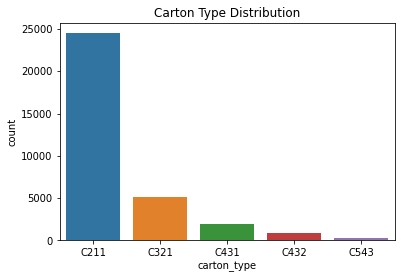

In [21]:
sns.countplot(x='carton_type',data=df_max)
plt.title('Carton Type Distribution')
plt.show()

In [22]:
df_max.carton_type.value_counts()

C211    24482
C321     5078
C431     1928
C432      904
C543      334
Name: carton_type, dtype: int64

As it turns out, there are 5 different carton types which make up the target variable. However, the distribution of the cartons are imbalanced. To solve this problem of imbalanced data classes, we will be resampling all the classes to a standard 1000 sample size.

In [23]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,len_mm,wid_mm,hgt_mm,sum_vol,qtyshipped,isgift,carton_type
orderkey,,,,,,,
2291743,89.0,89.0,36.0,0.285156,1,1,C211
2291745,89.0,89.0,36.0,0.285156,1,1,C211
2291760,104.0,83.0,59.0,0.509288,1,1,C211
2291768,145.0,91.0,42.0,0.554190,1,1,C211
2291772,89.0,89.0,36.0,0.285156,1,1,C211


In [24]:
# separate minority and majority classes
c211 = X[X.carton_type=='C211']
c321 = X[X.carton_type=='C321']
c431 = X[X.carton_type=='C431']
c432 = X[X.carton_type=='C432']
c543 = X[X.carton_type=='C543']

# resampling
c543_us = resample(c543,
                    replace=True, # sample with replacement
                    n_samples=1000, # number of samples is 1000
                    random_state=42) # reproducible results
c211_ds = resample(c211,
                    replace=False, # sample without replacement
                    n_samples=1000, # number of samples is 1000
                    random_state=42) # reproducible results
c321_ds = resample(c321,
                    replace=False, # sample without replacement
                    n_samples=1000, # number of samples is 1000
                    random_state=42) # reproducible results
c431_ds = resample(c431,
                    replace=False, # sample with replacement
                    n_samples=1000, # number of samples is 1000
                    random_state=42) # reproducible results
c432_ds = resample(c432,
                    replace=True, # sample with replacement
                    n_samples=1000, # number of samples is 1000
                    random_state=42) # reproducible results						  						  						  



# combine the sampled classes
resampled = pd.concat([c543_us,c211_ds,c321_ds,c431_ds,c432_ds])

# check new class counts
resampled.carton_type.value_counts()

C543    1000
C211    1000
C321    1000
C431    1000
C432    1000
Name: carton_type, dtype: int64

In [25]:
y_train = resampled.carton_type
X_train = resampled.drop('carton_type', axis=1)

Now that our training data is resampled and the classes of the target variable are balanced, scaling of the numeric features and one hot encoding of the categorical features will be done. 

Scaling of numeric features is done so that the machine learning model has an easier time learning and abnormally large numeric values will not bias the model.

In [26]:
ct = ColumnTransformer([
      ('scale', StandardScaler(),
      make_column_selector(dtype_include=np.number)),
      ('onehot', OneHotEncoder(),
      make_column_selector(dtype_include=object))])

In [27]:
ct.fit(X_train)

ColumnTransformer(transformers=[('scale', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023EE6915C70>),
                                ('onehot', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023EE6915D00>)])

In [28]:
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

### Machine Learning Modelling and Testing

For this project, 3 different classification models will be used, namely Logistic Regression, Random Forest Classifier and k-Nearest Neighbours (KNN).

#### Logistic Regression

Hyperparameter tuning will first be done using GridSearchCV. Subsequently, the best parameters for the estimator will be used in the final classifier model.

In [29]:
param_grid = {
    'penalty': ['l1','l2'],
    'C': np.logspace(-5, 8, 20),
}
# Create a based model
logreg = LogisticRegression(max_iter = 1000, random_state = 42,solver='saga')
# Instantiate the grid search model
logreg_gs = GridSearchCV(estimator = logreg, param_grid = param_grid, scoring = 'f1_weighted', 
                        cv = 5, n_jobs = 8, verbose = 2)
logreg_gs.fit(X_ttrain, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='saga'),
             n_jobs=8,
             param_grid={'C': array([1.00000000e-05, 4.83293024e-05, 2.33572147e-04, 1.12883789e-03,
       5.45559478e-03, 2.63665090e-02, 1.27427499e-01, 6.15848211e-01,
       2.97635144e+00, 1.43844989e+01, 6.95192796e+01, 3.35981829e+02,
       1.62377674e+03, 7.84759970e+03, 3.79269019e+04, 1.83298071e+05,
       8.85866790e+05, 4.28133240e+06, 2.06913808e+07, 1.00000000e+08]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=2)

In [30]:
logreg_gs.best_params_

{'C': 0.12742749857031346, 'penalty': 'l1'}

These hyperparameters will be used in the final model

In [31]:
logreg = LogisticRegression(C=0.1274,penalty='l1',solver='saga',random_state=42,max_iter=1000)
logreg.fit(X_ttrain, y_train)

LogisticRegression(C=0.1274, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

In [32]:
y_train_pred = logreg.predict(X_ttrain)

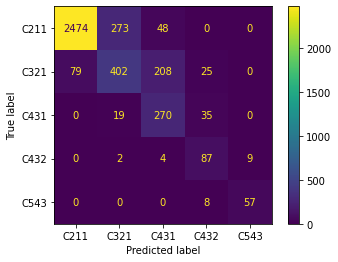

In [33]:
y_test_pred = logreg.predict(X_ttest)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=logreg.classes_).plot();


In [34]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        C211       0.97      0.89      0.93      2795
        C321       0.58      0.56      0.57       714
        C431       0.51      0.83      0.63       324
        C432       0.56      0.85      0.68       102
        C543       0.86      0.88      0.87        65

    accuracy                           0.82      4000
   macro avg       0.70      0.80      0.74      4000
weighted avg       0.85      0.82      0.83      4000



The f1-score for all the classes are moderately ok.

Logistic Regression seems to not be able to tackle this problem as effectively.

#### Random Forest

Hyperparameter tuning will first be done using GridSearchCV. Subsequently, the best parameters for the estimator will be used in the final classifier model.

In [35]:
param_grid = {
    'max_depth': [10,100,None],
    'max_features': ['sqrt','log2',None],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [10, 100],
    'criterion' : ['gini', 'entropy']
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
rfc_gs = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'f1_weighted', 
                        cv = 5, n_jobs = 8, verbose = 2)
rfc_gs.fit(X_ttrain, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 100, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [10, 100]},
             scoring='f1_weighted', verbose=2)

In [36]:
rfc_gs.best_params_

{'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

These hyperparameters will be used in the final model

In [37]:
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=100, min_samples_split=2, min_samples_leaf=1,random_state=42)
rfc.fit(X_ttrain, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, random_state=42)

In [38]:
%time y_train_pred = rfc.predict(X_ttrain)

Wall time: 61 ms


Recommendation of the carton only takes 0.046s for the combined model.

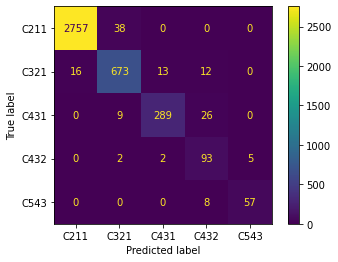

In [39]:
y_test_pred = rfc.predict(X_ttest)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=rfc.classes_).plot();


In [40]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        C211       0.99      0.99      0.99      2795
        C321       0.93      0.94      0.94       714
        C431       0.95      0.89      0.92       324
        C432       0.67      0.91      0.77       102
        C543       0.92      0.88      0.90        65

    accuracy                           0.97      4000
   macro avg       0.89      0.92      0.90      4000
weighted avg       0.97      0.97      0.97      4000



The f1-score for all the classes are good.

The Random Forest Classifier seems to be able to tackle this problem of carton recommendation quite well. Thus, this model will be used for tackling the carton recommendation problem.

#### KNN

Hyperparameter tuning will first be done using GridSearchCV. Subsequently, the best parameters for the estimator will be used in the final classifier model.

In [41]:
nn_range = np.arange(50, 5, -4)

knn_gs = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':nn_range}, 
                     scoring='f1_weighted', cv=5)

knn_gs.fit(X_ttrain, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10,  6])},
             scoring='f1_weighted')

In [42]:
knn_gs.best_params_

{'n_neighbors': 6}

These hyperparameters will be used in the final model

In [43]:
nn6 = KNeighborsClassifier(n_neighbors=6, n_jobs=8)
nn6.fit(X_ttrain, y_train)

KNeighborsClassifier(n_jobs=8, n_neighbors=6)

In [44]:
y_test_pred = nn6.predict(X_ttest)

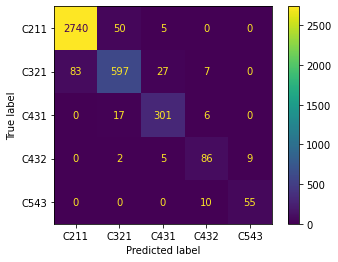

In [45]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=nn6.classes_).plot();

In [46]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        C211       0.97      0.98      0.98      2795
        C321       0.90      0.84      0.87       714
        C431       0.89      0.93      0.91       324
        C432       0.79      0.84      0.82       102
        C543       0.86      0.85      0.85        65

    accuracy                           0.94      4000
   macro avg       0.88      0.89      0.88      4000
weighted avg       0.94      0.94      0.94      4000



The f1-score for all the classes are good.

KNN classifier is able to classify the cartons effectively.

## Conclusion

The final model to be used for the recommender will be the Random Forest Classifier as mentioned above.

This model which integrates the heuristic and machine learning process is much more successful in classiifying the cartons across all the sizes. Thus, an integrated model is a viable approach to solving the carton recommendation problem.

There is however still room for potential future work which will be covered in the report.